In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

### Считывание и обработка датасета

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [4]:
# Количество в контрольной и экспериментальной группах
df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [5]:
# Количество просмотров новой и старой страниц
df.landing_page.value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [6]:
# Выборка бинарная
df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [7]:
# Для более удобной работы сделаем сводную таблицу
df_pivot = df.pivot_table(index='user_id', columns=['group', 'landing_page'], values='converted')
df_pivot.head(10)

group         control          treatment         
landing_page new_page old_page  new_page old_page
user_id                                          
630000            NaN      NaN       0.0      NaN
630001            NaN      NaN       1.0      NaN
630002            NaN      0.0       NaN      NaN
630003            NaN      NaN       0.0      NaN
630004            NaN      NaN       0.0      NaN
630005            NaN      NaN       1.0      NaN
630006            NaN      NaN       0.0      NaN
630008            NaN      0.0       NaN      NaN
630009            NaN      1.0       NaN      NaN
630010            NaN      NaN       0.0      NaN

In [8]:
# Получается две пары выборок - основная и дополнительная, видимо, для проверки правильности проведения самого теста.
# Пока видно, что доля конверсий у старой страницы выше, чем у новой. Проверим это позже с помощью z-test. 
df_pivot.describe()

group             control                     treatment             
landing_page     new_page       old_page       new_page     old_page
count         1928.000000  145274.000000  145310.000000  1965.000000
mean             0.121369       0.120386       0.118808     0.127226
std              0.326641       0.325414       0.323564     0.333311
min              0.000000       0.000000       0.000000     0.000000
25%              0.000000       0.000000       0.000000     0.000000
50%              0.000000       0.000000       0.000000     0.000000
75%              0.000000       0.000000       0.000000     0.000000
max              1.000000       1.000000       1.000000     1.000000

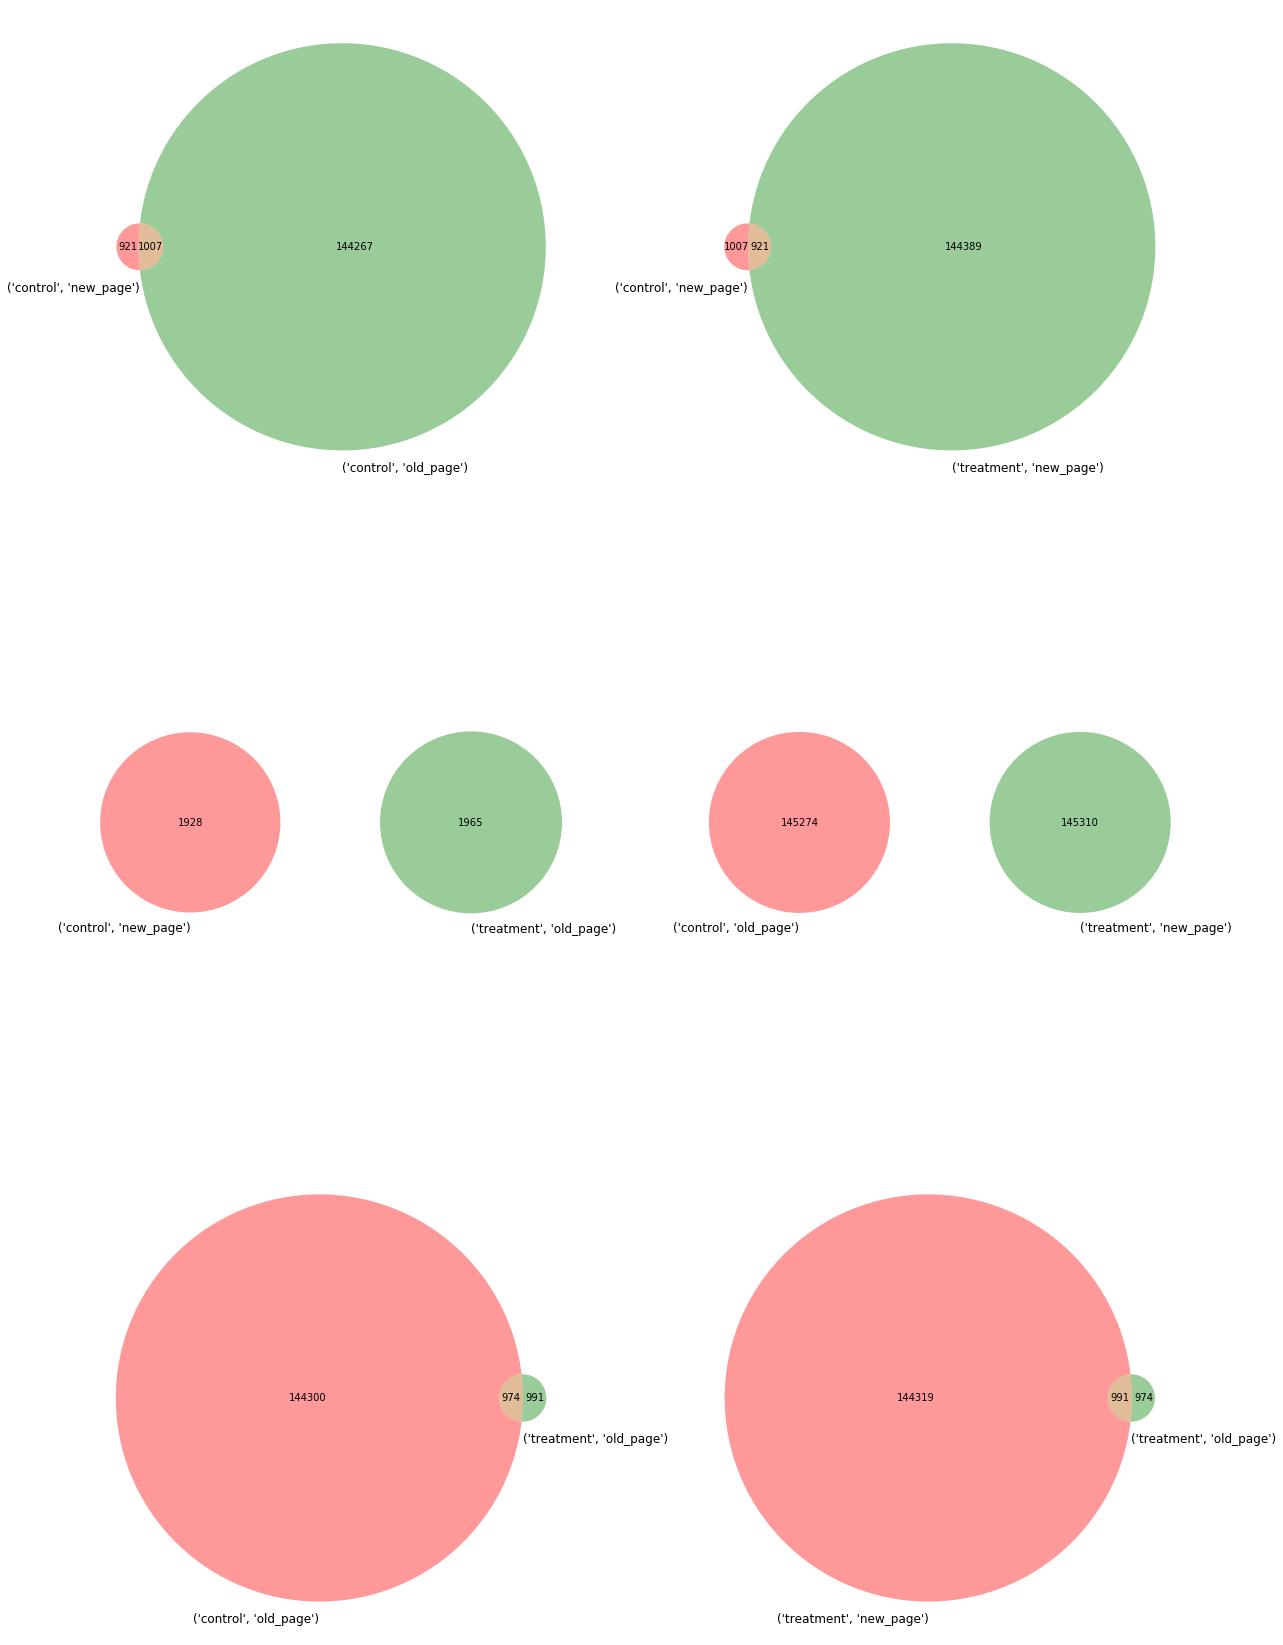

In [9]:
# Посмотрим на пересечение подмножеств.
# Видно, что в основной и дополнительной группах нет пересечений между контрольными и экспериментальными выборками,
# значит нужно использовать z-test независимых выборок.
# При этом дополнительная подгруппа сформирована из основной.
fig, axs = plt.subplots(3, 2, figsize=(20,30))
j = 0
for i in combinations(df_pivot.columns,2):
    set0 = set(df_pivot[df_pivot[i[0]].isnull()==False].index)
    set1 = set(df_pivot[df_pivot[i[1]].isnull()==False].index)
    ax = axs[j//2,j%2]
    ax = venn2([set0, set1], i, ax=ax)
    j += 1

### Доверительные интервалы разностей долей выборок и Z-test

In [10]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):
    """Функция получения доверительного интервала разности долей двух независимых выборок"""
    z = norm.ppf(1 - alpha / 2)
    
    p1 = sum(sample1) / len(sample1)
    p2 = sum(sample2) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)


def proportions_diff_z_test_ind(sample1, sample2, alternative = 'two-sided'):
    """Функция z-test для двух независимых выборок"""
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))
    elif alternative == 'less':
        p_value = norm.cdf(z_stat)
    elif alternative == 'greater':
        p_value = 1 - norm.cdf(z_stat)    
    
    return z_stat, p_value

In [11]:
# Составим выборки

# выборки основных групп:
control_old_page = df_pivot[df_pivot[('control', 'old_page')].isnull()==False][('control', 'old_page')]
treatment_new_page = df_pivot[df_pivot[('treatment', 'new_page')].isnull()==False][('treatment', 'new_page')]

# выборки дополнительных проверочных групп:
control_new_page = df_pivot[df_pivot[('control', 'new_page')].isnull()==False][('control', 'new_page')]
treatment_old_page = df_pivot[df_pivot[('treatment', 'old_page')].isnull()==False][('treatment', 'old_page')]

In [12]:
# В обеих группах в разность доверительных интервалов попадают нули, что говорит об отсутсвии значимых отличий долей
print('confidence interval main samples [{}, {}]'.format(*proportions_diff_confint_ind(control_old_page, 
                                                                                       treatment_new_page)))
print('confidence interval additional samples [{}, {}]'.format(*proportions_diff_confint_ind(treatment_old_page, 
                                                                                             control_new_page)))

confidence interval main samples [-0.0007813822743416229, 0.003937860245052736]
confidence interval additional samples [-0.014868412724632515, 0.026582749721665657]


In [13]:
# Z-test на достигаемом уровне значимости 0.05 так же не отвергает нулевую гипотезу о равенстве долей двух выборок в обоих группах
print('main samples two-sided p-value = {}'.format(proportions_diff_z_test_ind(control_old_page, 
                                                                               treatment_new_page)[1]))
print('additional samples two-sided p-value = {}'.format(proportions_diff_z_test_ind(treatment_old_page, 
                                                                                     control_new_page)[1]))

main samples two-sided p-value = 0.18988337448195103
additional samples two-sided p-value = 0.5797370422552168


In [14]:
# Одностронний правый z-test показал уменьшение p-value в обеих группах,
# но на достигаемом уровне значимости 0.05 нельзя принять альтернативную гипотезу о том, 
# что доля конверсий выборки со старой страницей выше, чем у новой.
print('main samples greater p-value = {}'.format(proportions_diff_z_test_ind(control_old_page, 
                                                                               treatment_new_page, 'greater')[1]))
print('additional samples greater p-value = {}'.format(proportions_diff_z_test_ind(treatment_old_page, 
                                                                             control_new_page, 'greater')[1]))

main samples greater p-value = 0.09494168724097551
additional samples greater p-value = 0.2898685211276084


### Вывод: доверительные интервалы разности долей и z-test показали, что доли значимо не отличаются, т.е. улучшений на новой странице нет.